In [6]:
import typing as t
from enum import Enum
from pathlib import Path

import kaggle_toolbox.features.transform as feature_transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from kaggle_toolbox.validation import analyze_val_strategy
from tqdm.notebook import tqdm

tqdm.pandas()
sns.set_context(
    'notebook',
    font_scale=0.75,
    # rc={'figure.figsize':(4.0, 3.5)},
)

In [7]:
TARGET_LIST = [
    'cohesion',
    'syntax',
    'vocabulary',
    'phraseology',
    'grammar',
    'conventions',
]
NUM_FOLDS = 5
SEED = 42

ROOT_DIR = Path('/kaggle')
DATA_DIR = ROOT_DIR / 'data'
FP_ELL_DATASET_DIR = DATA_DIR / 'fp-ell'
OOF_DIR = ROOT_DIR / 'oof'

class ModelId(str, Enum):
    a_b_s = 'a_b_s'
    d_b_s = 'd_b_s'
    d_l_s = 'd_l_s'
    k_b_m = 'k_b_m'
    a_b_m = 'a_b_m'


OOF_PATH_DICT = {
    ModelId.a_b_s: OOF_DIR / 'cv_preds_andrei_solo_target_base_5_folds.csv',
    ModelId.d_b_s: OOF_DIR / 'cv_preds_dima_solo_target_base_10_folds.csv',
    ModelId.d_l_s: OOF_DIR / 'cv_preds_dima_solo_target_large_10_folds.csv',
    ModelId.k_b_m: OOF_DIR / 'koj-awp-v3-base.csv',
    ModelId.a_b_m: OOF_DIR / 'v1-layer_norm-5fold.csv',
}

In [8]:
def _read_data(
        dataset_dir_path: Path,
        num_folds: int,
        seed: int) -> pd.DataFrame:
    all_df = pd.read_csv(dataset_dir_path / 'train.csv')
    target_arr = feature_transforms.contiguous_to_categorical(all_df[TARGET_LIST].values)

    mskf = MultilabelStratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
    for fold_, (_, v_) in enumerate(mskf.split(X=all_df, y=target_arr)):
        all_df.loc[v_, 'fold'] = fold_

    for oof_key in [ModelId.a_b_s, ModelId.d_b_s, ModelId.d_l_s]:
        all_df = all_df.merge(
            pd.read_csv(OOF_PATH_DICT[oof_key])
                .rename({
                    'id': 'text_id',
                    **{
                        target: f'{oof_key.value}_{target}_score'
                        for target in TARGET_LIST
                    }
                }, axis=1),
            left_on='text_id',
            right_on='text_id')

    all_df = all_df.merge(
        pd.read_csv(OOF_PATH_DICT[ModelId.a_b_m]).rename({
            'id': 'text_id',
            **{
                f'{target}_score': f'{ModelId.a_b_m.value}_{target}_score'
                for target in TARGET_LIST
            }
        }, axis=1),
        left_on='text_id',
        right_on='text_id')
    all_df = all_df.merge(
        pd.read_csv(OOF_PATH_DICT[ModelId.k_b_m]).rename({
            target: f'{ModelId.k_b_m.value}_{target}_score'
            for target in TARGET_LIST
        }, axis=1),
        left_on='text_id',
        right_on='text_id')

    return all_df

score_df = _read_data(
    dataset_dir_path=FP_ELL_DATASET_DIR,
    num_folds=NUM_FOLDS,
    seed=SEED)

analyze_val_strategy(score_df, target_list=TARGET_LIST, num_folds=NUM_FOLDS)

,fold,num_samples,cohesion_mean,syntax_mean,vocabulary_mean,phraseology_mean,grammar_mean,conventions_mean
0,0,782,3.077366,2.971867,3.205243,3.065857,2.959719,3.035166
1,1,783,3.125160,3.007024,3.226054,3.111111,3.015964,3.079183
2,2,782,3.140665,3.068414,3.258312,3.138747,3.069693,3.116368
3,3,782,3.131074,3.048593,3.245524,3.125959,3.042839,3.074169
4,4,782,3.161125,3.045396,3.243606,3.142583,3.076087,3.100384


In [9]:
score_df.head(3)

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,fold,a_b_s_cohesion_score,...,a_b_m_vocabulary_score,a_b_m_phraseology_score,a_b_m_grammar_score,a_b_m_conventions_score,k_b_m_cohesion_score,k_b_m_syntax_score,k_b_m_vocabulary_score,k_b_m_phraseology_score,k_b_m_grammar_score,k_b_m_conventions_score
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,1.0,2.855740,...,3.142851,3.163987,3.148065,3.014800,3.050259,2.991330,3.215425,3.227505,3.242692,2.957901
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,0.0,2.784366,...,2.858511,2.634341,2.465478,2.662711,2.783803,2.646464,2.897536,2.759491,2.462135,2.704659
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,4.0,2.891909,...,3.046087,2.960622,2.939112,2.984555,2.945666,2.971670,3.056777,3.002545,3.035044,3.195591


  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

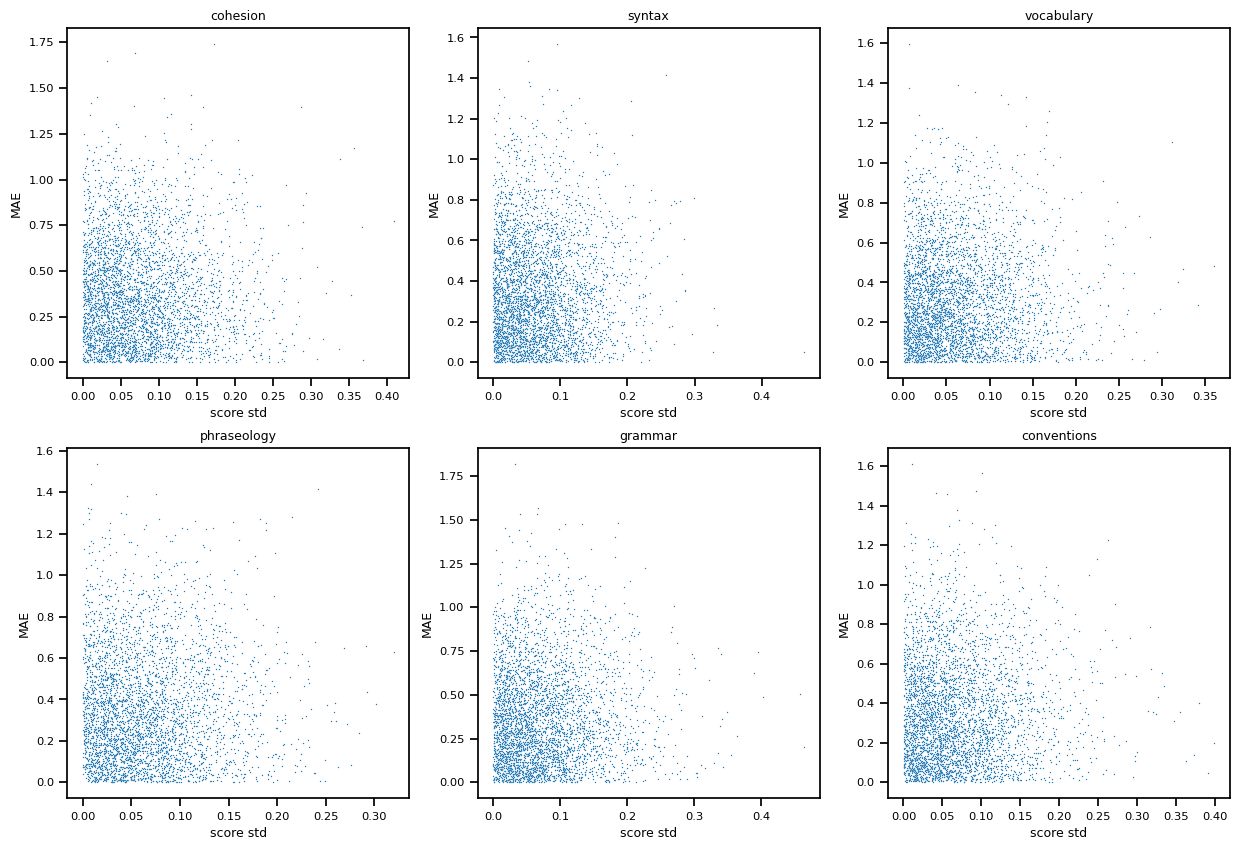

In [19]:
def plot_single_multi_diff_vs_error(
        score_df: pd.DataFrame,
        oof_key_list: t.List[str],
        target_list: t.List[str],
        max_std: t.Optional[float] = None):
    _, axes = plt.subplots(2, 3, figsize=(15, 10))
    for i, target in enumerate(target_list):
        score_std_srs = score_df.progress_apply(lambda row: np.array([row[f'{ok}_{target}_score'] for ok in oof_key_list]).std(), axis=1)
        single_mean_srs = (
            score_df[f'{ModelId.d_b_s.value}_{target}_score'] + 
            score_df[f'{ModelId.d_l_s.value}_{target}_score'] +
            score_df[f'{ModelId.a_b_s.value}_{target}_score']) / 3
        multi_mean_srs = (
            score_df[f'{ModelId.a_b_m.value}_{target}_score'] +
            score_df[f'{ModelId.k_b_m.value}_{target}_score']) / 2
        diff_srs = (single_mean_srs - multi_mean_srs).abs()
        mae_srs = score_df.progress_apply(lambda row: abs(np.array([row[f'{ok}_{target}_score'] for ok in oof_key_list]).mean() - row[target]), axis=1)
        if max_std:
            mask = score_std_srs < max_std
            score_std_srs = score_std_srs[mask]
            mae_srs = mae_srs[mask]
        ax = axes[i // 3][i % 3]
        ax.set_title(target)
        ax.set_xlabel('diff')
        ax.set_ylabel('MAE')
        sns.scatterplot(x=diff_srs, y=mae_srs, ax=ax, s=1)

plot_single_multi_diff_vs_error(score_df=score_df, oof_key_list=list(OOF_PATH_DICT.keys()), target_list=TARGET_LIST)

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

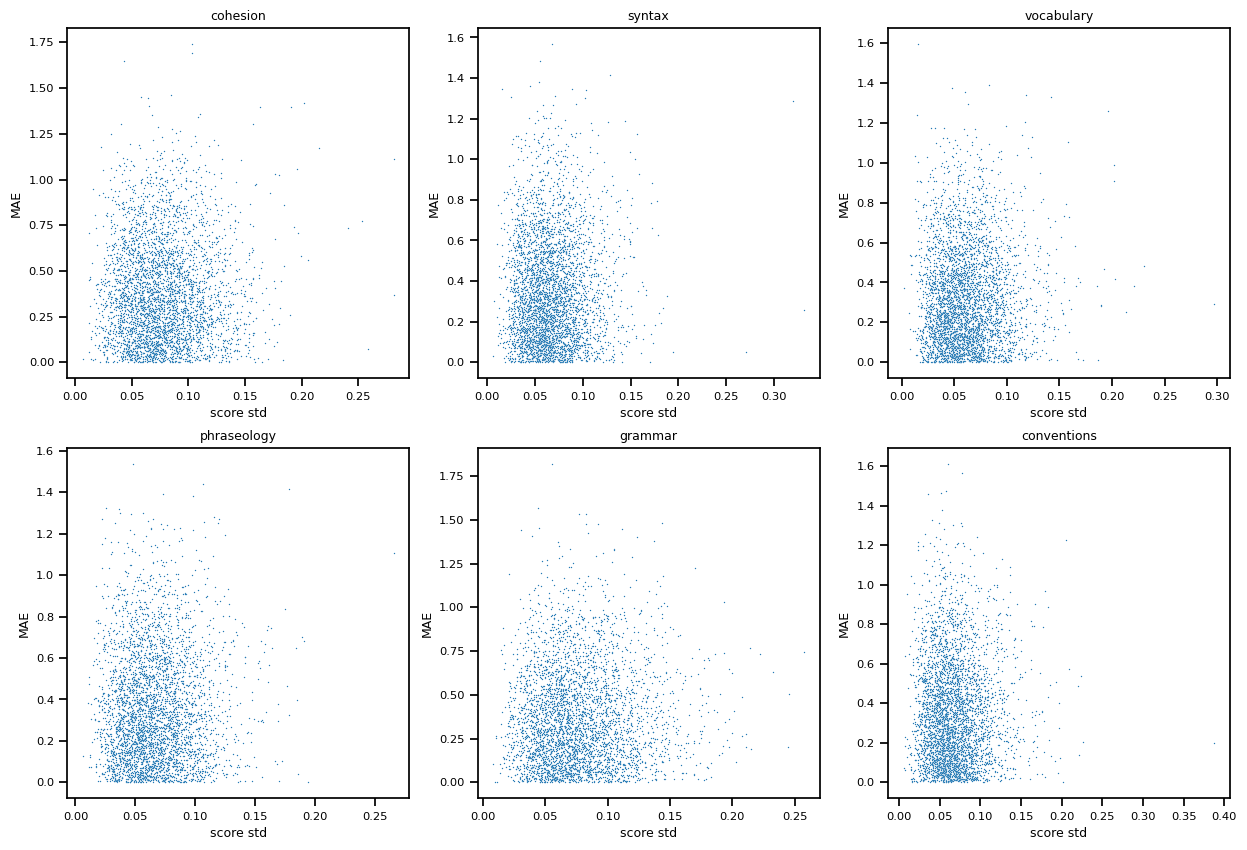

In [10]:
def plot_score_std_vs_error(
        score_df: pd.DataFrame,
        oof_key_list: t.List[str],
        target_list: t.List[str],
        max_std: t.Optional[float] = None):
    _, axes = plt.subplots(2, 3, figsize=(15, 10))
    for i, target in enumerate(target_list):
        score_std_srs = score_df.progress_apply(lambda row: np.array([row[f'{ok}_{target}_score'] for ok in oof_key_list]).std(), axis=1)
        mae_srs = score_df.progress_apply(lambda row: abs(np.array([row[f'{ok}_{target}_score'] for ok in oof_key_list]).mean() - row[target]), axis=1)
        if max_std:
            mask = score_std_srs < max_std
            score_std_srs = score_std_srs[mask]
            mae_srs = mae_srs[mask]
        ax = axes[i // 3][i % 3]
        ax.set_title(target)
        ax.set_xlabel('score std')
        ax.set_ylabel('MAE')
        sns.scatterplot(x=score_std_srs, y=mae_srs, ax=ax, s=1)

plot_score_std_vs_error(score_df=score_df, oof_key_list=list(OOF_PATH_DICT.keys()), target_list=TARGET_LIST)

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

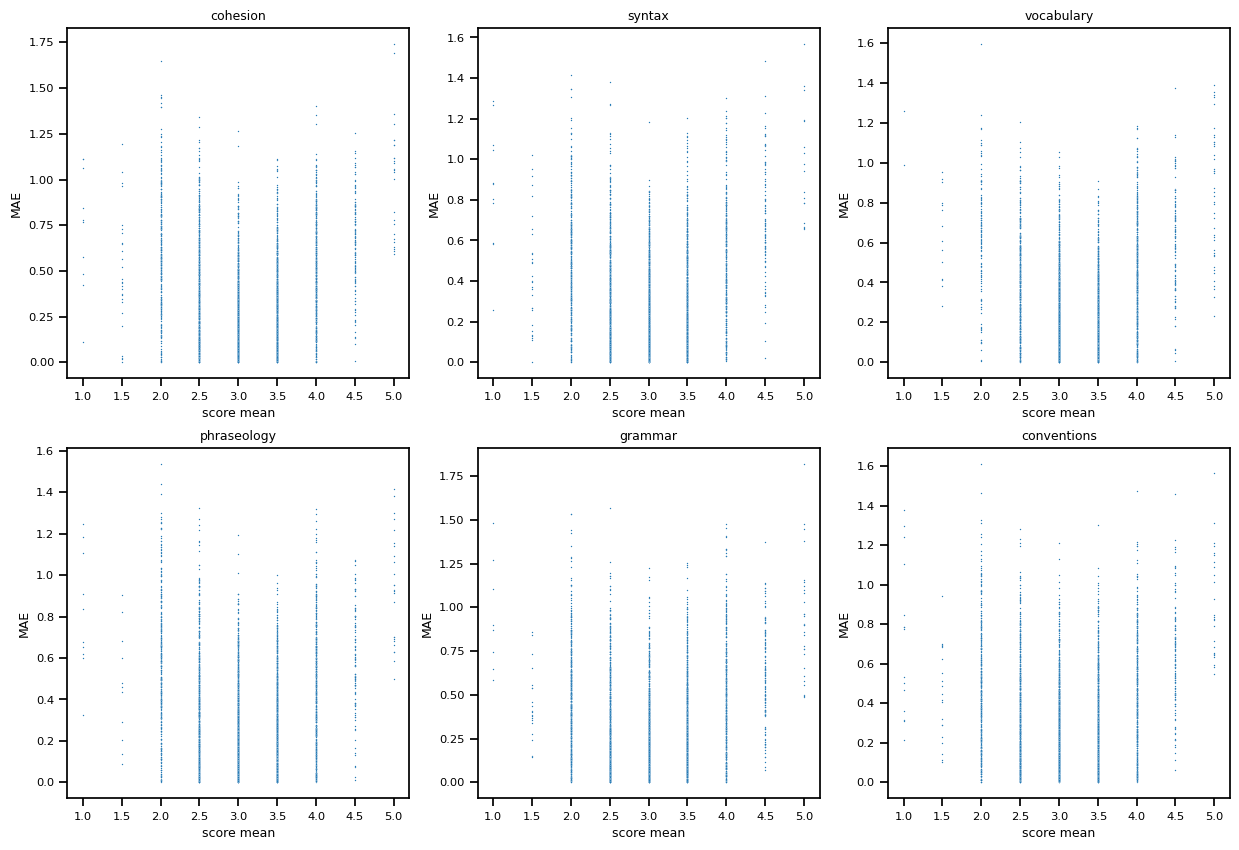

In [11]:
def plot_target_score_vs_error(
        score_df: pd.DataFrame,
        oof_key_list: t.List[str],
        target_list: t.List[str]):
    _, axes = plt.subplots(2, 3, figsize=(15, 10))
    for i, target in enumerate(target_list):
        score_target_srs = score_df[target]
        mae_srs = score_df.progress_apply(lambda row: abs(np.array([row[f'{ok}_{target}_score'] for ok in oof_key_list]).mean() - row[target]), axis=1)
        ax = axes[i // 3][i % 3]
        ax.set_title(target)
        ax.set_xlabel('score mean')
        ax.set_ylabel('MAE')
        sns.scatterplot(x=score_target_srs, y=mae_srs, ax=ax, s=1)

plot_target_score_vs_error(score_df=score_df, oof_key_list=list(OOF_PATH_DICT.keys()), target_list=TARGET_LIST)

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

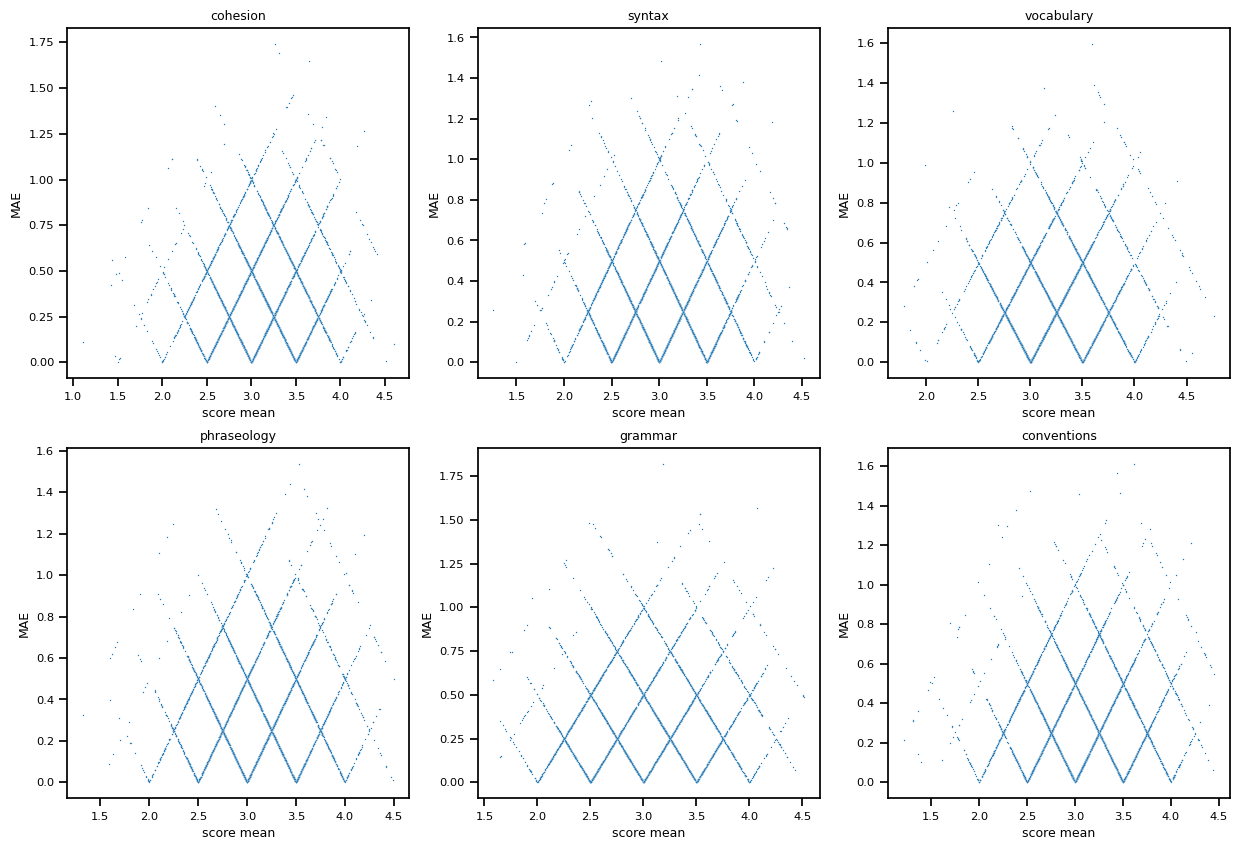

In [12]:
def plot_score_mean_vs_error(
        score_df: pd.DataFrame,
        oof_key_list: t.List[str],
        target_list: t.List[str]):
    _, axes = plt.subplots(2, 3, figsize=(15, 10))
    for i, target in enumerate(target_list):
        score_mean_srs = score_df.progress_apply(lambda row: np.array([row[f'{ok}_{target}_score'] for ok in oof_key_list]).mean(), axis=1)
        mae_srs = score_df.progress_apply(lambda row: abs(np.array([row[f'{ok}_{target}_score'] for ok in oof_key_list]).mean() - row[target]), axis=1)
        ax = axes[i // 3][i % 3]
        ax.set_title(target)
        ax.set_xlabel('score mean')
        ax.set_ylabel('MAE')
        sns.scatterplot(x=score_mean_srs, y=mae_srs, ax=ax, s=1)

plot_score_mean_vs_error(score_df=score_df, oof_key_list=list(OOF_PATH_DICT.keys()), target_list=TARGET_LIST)

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

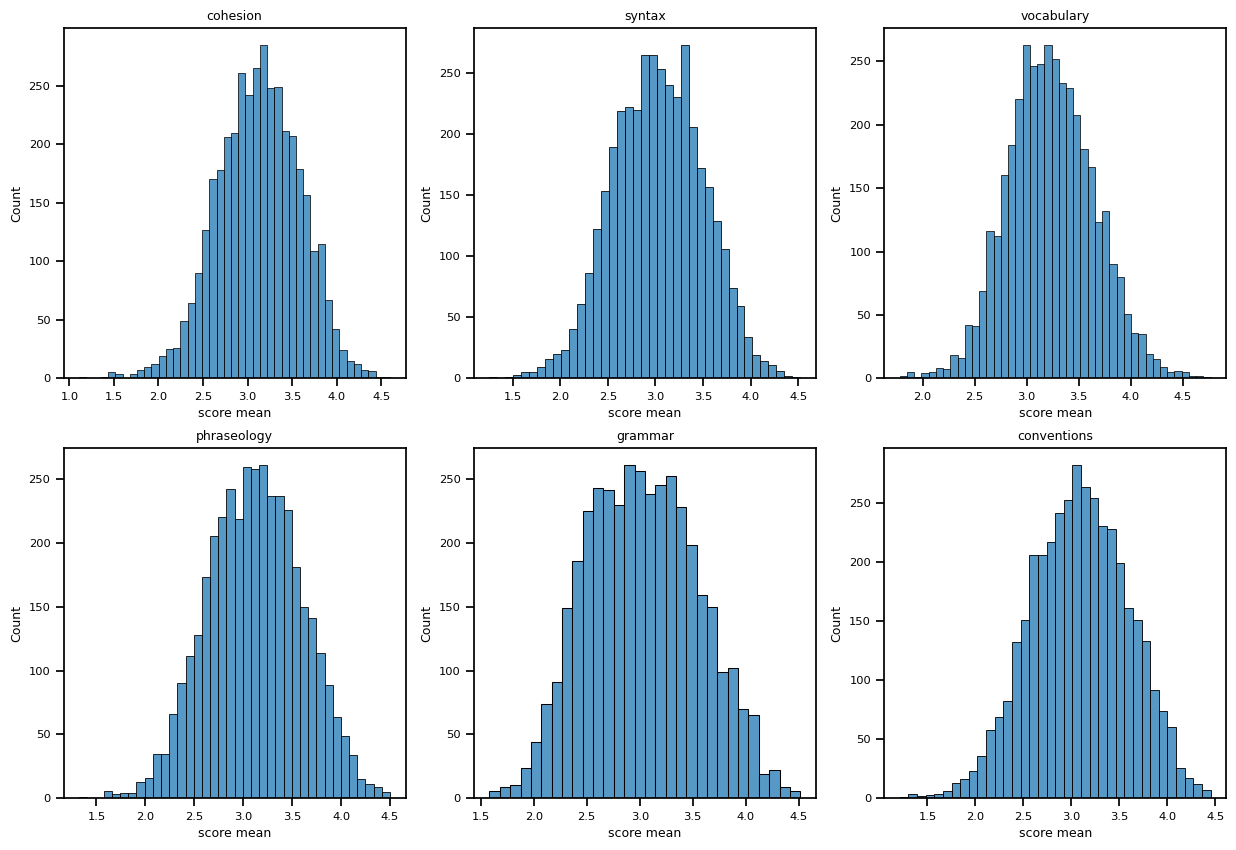

In [13]:
def plot_score_mean_distr(
        score_df: pd.DataFrame,
        oof_key_list: t.List[str],
        target_list: t.List[str]):
    _, axes = plt.subplots(2, 3, figsize=(15, 10))
    for i, target in enumerate(target_list):
        score_mean_srs = score_df.progress_apply(lambda row: np.array([row[f'{ok}_{target}_score'] for ok in oof_key_list]).mean(), axis=1)
        ax = axes[i // 3][i % 3]
        ax.set_title(target)
        ax.set_xlabel('score mean')
        sns.histplot(x=score_mean_srs, ax=ax)

plot_score_mean_distr(score_df=score_df, oof_key_list=list(OOF_PATH_DICT.keys()), target_list=TARGET_LIST)

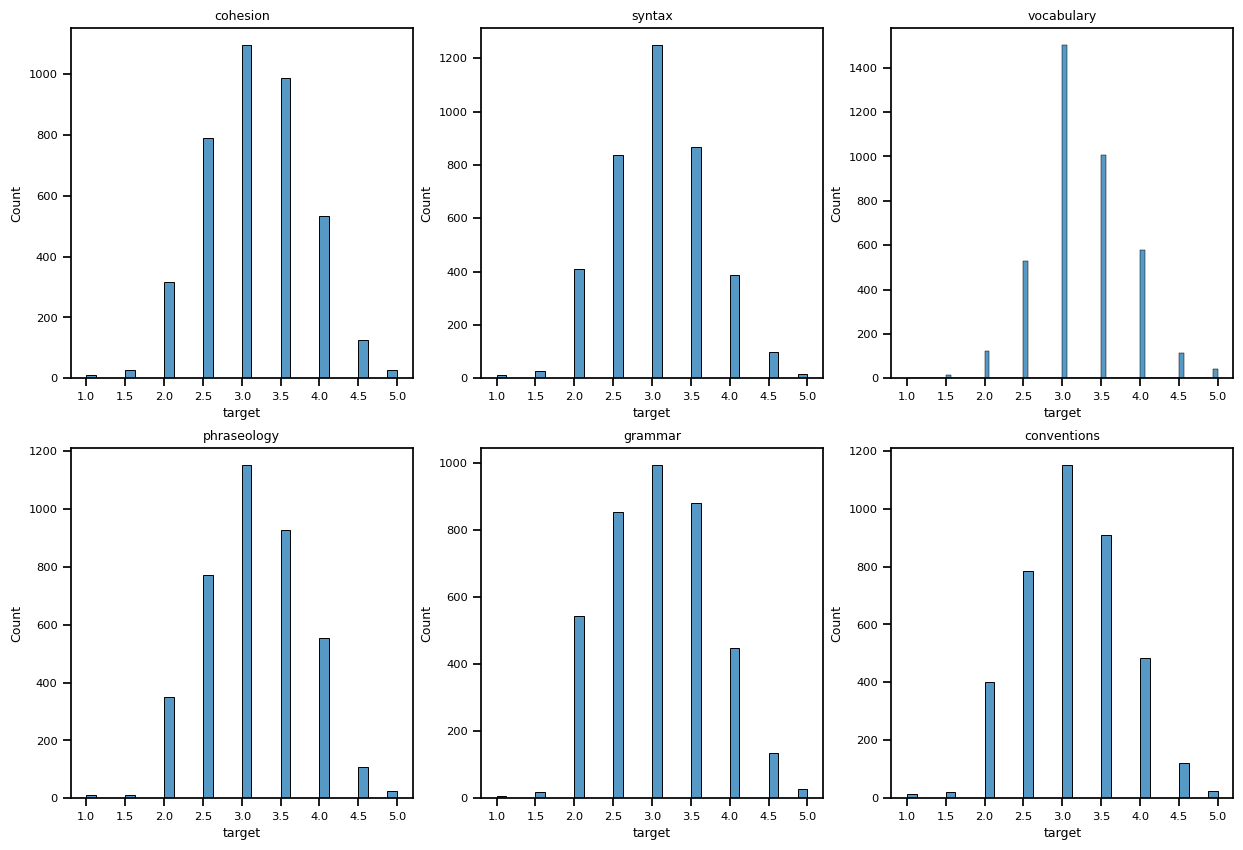

In [14]:
def plot_target_distr(
        score_df: pd.DataFrame,
        target_list: t.List[str]):
    _, axes = plt.subplots(2, 3, figsize=(15, 10))
    for i, target in enumerate(target_list):
        target_srs = score_df[target]
        ax = axes[i // 3][i % 3]
        ax.set_title(target)
        ax.set_xlabel('target')
        sns.histplot(x=target_srs, ax=ax)

plot_target_distr(score_df=score_df, target_list=TARGET_LIST)

In [15]:
import functools

import kaggle_toolbox.features.generation as features
import kaggle_toolbox.nlp.features as text_features
from kaggle_toolbox.progress import NotebookProgressBar
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from textstat import textstat

In [16]:
def _get_feature_generator_list(
        oof_key_list: t.List[str],
        target: str,
        ) -> t.List[t.Union[features.FeatureGenerator, text_features.TextFeatureGenerator]]:
    pred_col_list = [f'{ok}_{target}_score' for ok in oof_key_list]
    return [
        # Score-based
        features.Mean(name='score_mean', feature_list=pred_col_list),
        features.Stdev(name='score_std', feature_list=pred_col_list),
        # Custom simple
        text_features.SubstrCount(name='num_commas', substr=','),
        text_features.SubstrCount(name='num_dots', substr='.'),
        text_features.SubstrCount(name='num_colons', substr=':'),
        text_features.SubstrCount(name='num_semicolons', substr=';'),
        text_features.SubstrCount(name='num_ellipsis', substr='...'),
        text_features.SubstrCount(name='num_newlines', substr='\n'),
        text_features.SubstrCount(name='num_spaces', substr=' '),
        # TextStat simple
        text_features.Func(name='syllable_count', func=textstat.syllable_count),
        text_features.Func(name='lexicon_count', func=functools.partial(textstat.lexicon_count, removepunct=True)),
        text_features.Func(name='char_count', func=functools.partial(textstat.char_count, ignore_spaces=True)),
        text_features.Func(name='letter_count', func=functools.partial(textstat.letter_count, ignore_spaces=True)),
        text_features.Func(name='polysyllabcount', func=functools.partial(textstat.polysyllabcount)),
        text_features.Func(name='monosyllabcount', func=functools.partial(textstat.monosyllabcount)),
        # Custom complex
        features.Div(name='ratio_commas', lhs_feature='num_commas', rhs_feature='char_count'),
        features.Div(name='ratio_dots', lhs_feature='num_dots', rhs_feature='char_count'),
        features.Div(name='ratio_colons', lhs_feature='num_colons', rhs_feature='char_count'),
        features.Div(name='ratio_semicolons', lhs_feature='num_semicolons', rhs_feature='char_count'),
        features.Div(name='ratio_ellipsis', lhs_feature='num_ellipsis', rhs_feature='char_count'),
        features.Div(name='ratio_newlines', lhs_feature='num_newlines', rhs_feature='char_count'),
        features.Div(name='ratio_spaces', lhs_feature='num_spaces', rhs_feature='char_count'),
        # TextStat complex
        text_features.Func(name='flesch_reading_ease', func=textstat.flesch_reading_ease),
        text_features.Func(name='flesch_kincaid_grade', func=textstat.flesch_kincaid_grade),
        text_features.Func(name='gunning_fog', func=textstat.gunning_fog),
        text_features.Func(name='smog_index', func=textstat.smog_index),
        text_features.Func(name='automated_readability_index', func=textstat.automated_readability_index),
        text_features.Func(name='coleman_liau_index', func=textstat.coleman_liau_index),
        text_features.Func(name='linsear_write_formula', func=textstat.linsear_write_formula),
        text_features.Func(name='dale_chall_readability_score', func=textstat.dale_chall_readability_score),
        text_features.Func(name='text_standard', func=functools.partial(textstat.text_standard, float_output=True)),  # type: ignore
        text_features.Func(name='spache_readability', func=textstat.spache_readability),
        text_features.Func(name='mcalpine_eflaw', func=textstat.mcalpine_eflaw),
        text_features.Func(name='reading_time', func=functools.partial(textstat.reading_time, ms_per_char=14.69)),
    ]


def build_features(
        df: pd.DataFrame,
        oof_key_list: t.List[str],
        target: str,) -> t.Tuple[pd.DataFrame, t.Set[str]]:
    df = df.copy()
    text_srs = df['full_text']

    feature_arr_dict = text_features.generate_text_features(
        generator_list=_get_feature_generator_list(
            oof_key_list=oof_key_list,
            target=target),
        text_seq=text_srs.tolist(),
        progress_bar=NotebookProgressBar(),
        init_feature_array_dict={
            f'{ok}_{target}_score': df[f'{ok}_{target}_score'].values
            for ok in oof_key_list
        })  # type: ignore
    for feature_name, feature_arr in feature_arr_dict.items():
        df[feature_name] = feature_arr

    return df, set(feature_arr_dict.keys())


def _get_xy(df: pd.DataFrame, target: str, feature_whitelist: t.Set[str]) -> t.Tuple[np.ndarray, np.ndarray]:
    x_arr = df[[
        col for col in sorted(df.columns)
        if col in feature_whitelist
    ]].values
    y_arr = ((df['score_mean'] - df[target]).abs() <= 0.25).values.astype(np.int32)
    return x_arr, y_arr


def train_weak_rounding_classifier(
        df: pd.DataFrame,
        feature_whitelist: t.Set[str],
        target: str,
        fold_list: t.List[int],
        threshold_list: t.List[float]):
    for fold in fold_list:
        train_df, valid_df = df[df['fold'] != fold], df[df['fold'] == fold]
        train_x, train_y = _get_xy(train_df, target=target, feature_whitelist=feature_whitelist)
        valid_x, valid_y = _get_xy(valid_df, target=target, feature_whitelist=feature_whitelist)
        model = DecisionTreeClassifier(max_depth=16)
        # print(model.max_depth)
        model.fit(train_x, train_y)
        valid_pred_prob = model.predict_proba(valid_x)
        # print(valid_pred_prob[:2,])
        f1_at_t_list = [
            f1_score(valid_y, (valid_pred_prob[:, 1] >= t))
            for t in threshold_list
        ]
        precision_at_t_list = [
            precision_score(valid_y, (valid_pred_prob[:, 1] >= t))
            for t in threshold_list
        ]
        recall_at_t_list = [
            recall_score(valid_y, (valid_pred_prob[:, 1] >= t))
            for t in threshold_list
        ]
        print(f'fold = {fold}')
        print('f1: ' + ', '.join([f'{f1:.3f} at {t:.2f}' for t, f1 in zip(threshold_list, f1_at_t_list)]))
        print('pr: ' + ', '.join([f'{pr:.3f} at {t:.2f}' for t, pr in zip(threshold_list, precision_at_t_list)]))
        print('re: ' + ', '.join([f'{re:.3f} at {t:.2f}' for t, re in zip(threshold_list, recall_at_t_list)]))


In [17]:
wrc_df, wrc_feature_whitelist = build_features(score_df, oof_key_list=list(OOF_PATH_DICT.keys()), target='cohesion')

score_mean:   0%|          | 0/3911 [00:00<?, ?it/s]

score_std:   0%|          | 0/3911 [00:00<?, ?it/s]

num_commas:   0%|          | 0/3911 [00:00<?, ?it/s]

num_dots:   0%|          | 0/3911 [00:00<?, ?it/s]

num_colons:   0%|          | 0/3911 [00:00<?, ?it/s]

num_semicolons:   0%|          | 0/3911 [00:00<?, ?it/s]

num_ellipsis:   0%|          | 0/3911 [00:00<?, ?it/s]

num_newlines:   0%|          | 0/3911 [00:00<?, ?it/s]

num_spaces:   0%|          | 0/3911 [00:00<?, ?it/s]

syllable_count:   0%|          | 0/3911 [00:00<?, ?it/s]

lexicon_count:   0%|          | 0/3911 [00:00<?, ?it/s]

char_count:   0%|          | 0/3911 [00:00<?, ?it/s]

letter_count:   0%|          | 0/3911 [00:00<?, ?it/s]

polysyllabcount:   0%|          | 0/3911 [00:00<?, ?it/s]

monosyllabcount:   0%|          | 0/3911 [00:00<?, ?it/s]

ratio_commas:   0%|          | 0/3911 [00:00<?, ?it/s]

ratio_dots:   0%|          | 0/3911 [00:00<?, ?it/s]

ratio_colons:   0%|          | 0/3911 [00:00<?, ?it/s]

ratio_semicolons:   0%|          | 0/3911 [00:00<?, ?it/s]

ratio_ellipsis:   0%|          | 0/3911 [00:00<?, ?it/s]

ratio_newlines:   0%|          | 0/3911 [00:00<?, ?it/s]

ratio_spaces:   0%|          | 0/3911 [00:00<?, ?it/s]

flesch_reading_ease:   0%|          | 0/3911 [00:00<?, ?it/s]

flesch_kincaid_grade:   0%|          | 0/3911 [00:00<?, ?it/s]

gunning_fog:   0%|          | 0/3911 [00:00<?, ?it/s]

smog_index:   0%|          | 0/3911 [00:00<?, ?it/s]

automated_readability_index:   0%|          | 0/3911 [00:00<?, ?it/s]

coleman_liau_index:   0%|          | 0/3911 [00:00<?, ?it/s]

linsear_write_formula:   0%|          | 0/3911 [00:00<?, ?it/s]

dale_chall_readability_score:   0%|          | 0/3911 [00:00<?, ?it/s]

text_standard:   0%|          | 0/3911 [00:00<?, ?it/s]

spache_readability:   0%|          | 0/3911 [00:00<?, ?it/s]

mcalpine_eflaw:   0%|          | 0/3911 [00:00<?, ?it/s]

reading_time:   0%|          | 0/3911 [00:00<?, ?it/s]

In [18]:
train_weak_rounding_classifier(
    df=wrc_df,
    feature_whitelist=wrc_feature_whitelist,
    target='cohesion',
    fold_list=list(range(NUM_FOLDS)),
    threshold_list=[0.5])

fold = 0
f1: 0.296 at 0.50
pr: 0.343 at 0.50
re: 0.260 at 0.50
fold = 1
f1: 0.335 at 0.50
pr: 0.437 at 0.50
re: 0.272 at 0.50
fold = 2
f1: 0.347 at 0.50
pr: 0.421 at 0.50
re: 0.295 at 0.50
fold = 3
f1: 0.241 at 0.50
pr: 0.397 at 0.50
re: 0.173 at 0.50
fold = 4
f1: 0.399 at 0.50
pr: 0.406 at 0.50
re: 0.392 at 0.50
